In [1]:
import sys

import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

sys.path.append('../../src')
from utility import video
from utility.transform import Homography

In [2]:
def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [32]:
# file path
room_num = "05"
surgery_num = "20211109"
video_path = f"../../video/{room_num}/{surgery_num}/08.mp4"
field_path = "../../image/field.png"
print(video_path)
print(field_path)

../../video/05/20211109/08.mp4
../../image/field.png


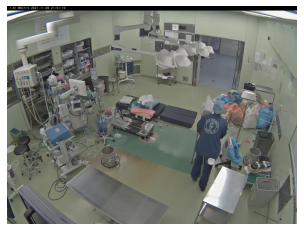

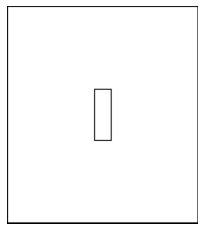

In [33]:
# open video and image
cap = video.Capture(video_path)
cap.set_pos_frame_count(130000)
_, frame = cap.read()
show_img(frame)

field = cv2.imread(field_path)
show_img(field)

In [34]:
cv2.imwrite("../../image/05.png", frame)

True

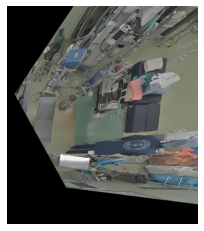

In [67]:
p_video = np.float32([[480, 548], [532, 509], [840, 586], [812, 640]])
p_field = np.float32([[271, 255], [321, 255], [321, 412], [271, 412]])
homo = Homography(p_video, p_field, field.shape)
frame_homo = homo.transform_image(frame)
show_img(frame_homo)